In [1]:
from pyjetty.mputils.mputils import logbins
import operator as op
import itertools as it
import sys
import os
import argparse
from tqdm import tqdm
from heppy.pythiautils import configuration as pyconf
import pythiaext
import pythiafjext
import pythia8
import fjtools
import ecorrel
import fjcontrib
import fjext
import fastjet as fj
from tqdm import tqdm
import argparse
import os

Welcome to JupyROOT 6.24/02


In [2]:
def get_args_from_settings(ssettings):
    sys.argv=[' '] + ssettings.split()
    parser = argparse.ArgumentParser(description='pythia8 fastjet on the fly')
    pyconf.add_standard_pythia_args(parser)
    parser.add_argument('--output', default="test_ang_ue.root", type=str)
    parser.add_argument('--user-seed', help='pythia seed', default=1111, type=int)
    args = parser.parse_args()
    return args

In [13]:
pt_hat_min = 500
def get_pythia():
    mycfg = []
    ssettings = "--py-ecm 7000 --py-pthatmin {}".format(pt_hat_min)
    args = get_args_from_settings(ssettings)
    pythia_hard = pyconf.create_and_init_pythia_from_args(args, mycfg)
    return pythia_hard

In [14]:
jet_R0 = 0.4
max_eta_jet = 1.9 # open CMS data
max_eta_hadron = 10.
parts_selector_h = fj.SelectorAbsEtaMax(max_eta_hadron)
# jet_selector = fj.SelectorPtMin(500.0) & fj.SelectorPtMax(550.0) & fj.SelectorAbsEtaMax(max_eta_hadron - 1.05 * jet_R0)
jet_selector = fj.SelectorPtMin(pt_hat_min) & fj.SelectorPtMax(pt_hat_min*1.2) & fj.SelectorAbsEtaMax(max_eta_jet) 
pfc_selector0 = fj.SelectorPtMin(0.)
pfc_selector1 = fj.SelectorPtMin(1.)
# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
print(jet_def)



Longitudinally invariant anti-kt algorithm with R = 0.4 and E scheme recombination


In [15]:
pythia_hard = get_pythia()
def get_next_jet():
    while 1:
        if not pythia_hard.next():
            continue
        # parts_pythia_h = pythiafjext.vectorize_select(pythia_hard, [pythiafjext.kFinal, pythiafjext.kCharged], 0, True)
        parts_pythia_h = pythiafjext.vectorize_select(pythia_hard, [pythiafjext.kFinal], 0, False )
        parts_pythia_h_selected = parts_selector_h(parts_pythia_h)

        jets_h = fj.sorted_by_pt(jet_selector(jet_def(parts_pythia_h_selected))) 
        if len(jets_h) < 1:
            continue
        return jets_h[0]

['HardQCD:all=on', 'PhaseSpace:pTHatMin = 500.0', 'Beams:eCM = 7000.0']
[i] strings read to PYTHIA  [['HardQCD:all=on', 'PhaseSpace:pTHatMin = 500.0', 'Beams:eCM = 7000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['HardQCD:all=on', 'PhaseSpace:pTHatMin = 500.0', 'Beams:eCM = 7000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |

In [16]:
j = get_next_jet()

In [17]:
print(j)

[565.492774, 75.035433, 93.855240, 580.467626]


In [18]:
consts = fj.sorted_by_pt(j.constituents())
points = []
points_voronoi = []
for c in consts:
    col = c.perp()/j.perp()
    ix = (c.eta() - j.eta()) / jet_R0 / 2.
    iy = c.delta_phi_to(j) / jet_R0 / 2.
    points.append([ix,iy, col])
    points_voronoi.append([ix,iy])

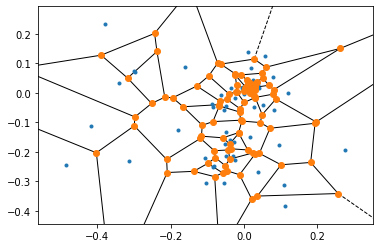

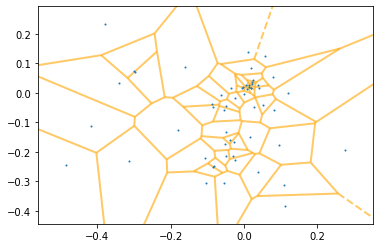

In [19]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points_voronoi)
fig = voronoi_plot_2d(vor)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
plt.show()

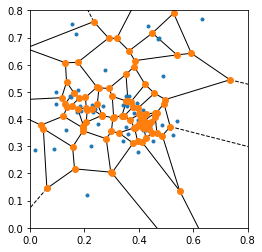

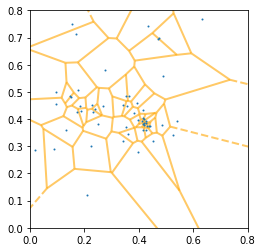

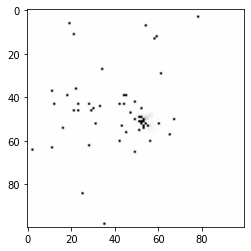

In [21]:
plot1, plot2 = voronoi_pixels(j)

In [38]:
import math
def pixelize_voronoi(imd3, points):  
    for ix in range(100):
        for iy in range(100):
            _dmin = 1.e4
            _dminxy = [-1,-1]
            _dmincol = -1
            for i,p in enumerate(points):
                _d = math.sqrt(math.pow((p[0]-ix), 2) + math.pow((p[1]-iy),2))
                if _d <= _dmin:
                    _dmin = _d
                    _dminxy[0] = ix
                    _dminxy[1] = iy
                    _dmincol = points[i][2]
            if _dmin >= 1.:
                imd3[ix][iy][0]=1.-_dmincol/_dmin
                imd3[ix][iy][1]=1.-_dmincol/_dmin
                imd3[ix][iy][2]=1.-_dmincol/_dmin
    for i,p_img in enumerate(points):
        #print(p_img)
        imd3[p_img[0]][p_img[1]][0]=p[2]
        imd3[p_img[0]][p_img[1]][1]=p[2]
        imd3[p_img[0]][p_img[1]][2]=p[2]

def voronoi_pixels(j):
    imd = np.ones(100*100*3)
    imd3=np.reshape(imd, (100,100,3))
    consts = fj.sorted_by_pt(j.constituents())
    points = []
    points_voronoi = []
    points_img = []
    colmax = max([c.perp()/j.perp() for c in consts])
    colmin = min([c.perp()/j.perp() for c in consts])
    for c in consts:
        col = c.perp()/j.perp()
        ix = (c.rap() - j.rap()) / jet_R0 / 2. + jet_R0
        iy = c.delta_phi_to(j) / jet_R0 / 2. + jet_R0
        # need to make sharp cuts in R
        if ix > jet_R0 * 2.:
            continue
        if iy > jet_R0 * 2.:
            continue
        points.append([ix, iy, col])
        points_voronoi.append([iy, 2.*jet_R0-ix])
    if len(consts) > 4:
        vor = Voronoi(points_voronoi)
        fig = voronoi_plot_2d(vor)
        plt.xlim(0, 2.*jet_R0)
        plt.ylim(0, 2.*jet_R0)
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.show()
        fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
        plt.xlim(0, 2.*jet_R0)
        plt.ylim(0, 2.*jet_R0)
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.show()
    # print(points)
    pixel_scale = 100. / jet_R0 / 2.
    for i,p in enumerate(points):
        p_img = [int(p[0]*pixel_scale), int(p[1]*pixel_scale), p[2]]
        points_img.append(p_img)
        #print(p_img)
        imd3[p_img[0]][p_img[1]][0]=p[2]
        imd3[p_img[0]][p_img[1]][1]=1
        imd3[p_img[0]][p_img[1]][2]=1
    imgplot1 = None
    # imgplot1 = plt.imshow(imd3)
    # now do the voronoi areas
    pixelize_voronoi(imd3, points_img)
    imgplot2 = None
    imgplot2 = plt.imshow(imd3)
    return imgplot1, imgplot2

[132.898672, -549.485149, 194.680053, 603.808094] ----


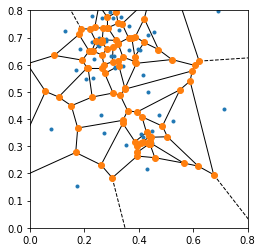

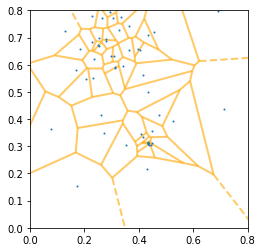

[428.291325, -389.519412, -451.458746, 736.009491] ----


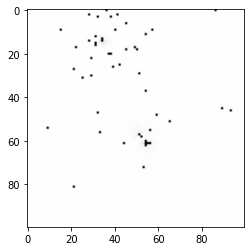

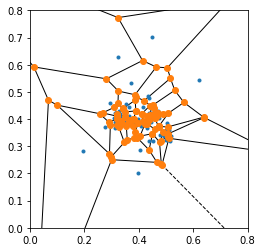

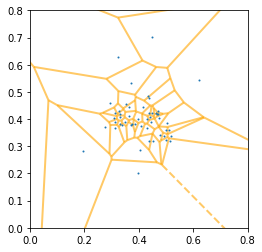

[481.872852, 224.288401, -106.202075, 543.683354] ----


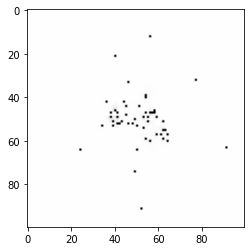

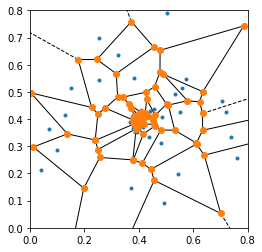

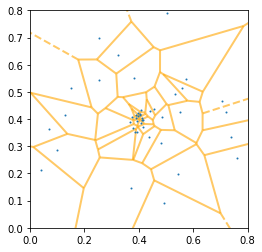

[-480.944413, -257.486949, -1680.363579, 1767.447042] ----


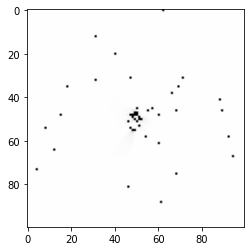

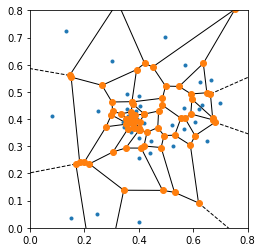

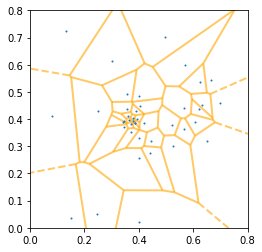

[361.845120, -446.111214, -767.180257, 959.313303] ----


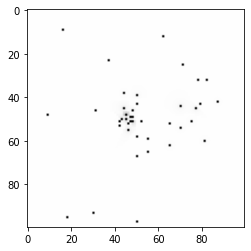

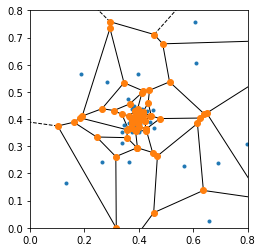

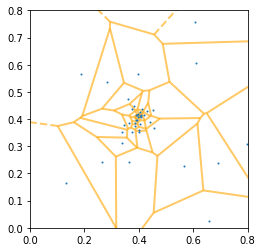

[519.916602, 120.274596, 9.564073, 534.821953] ----


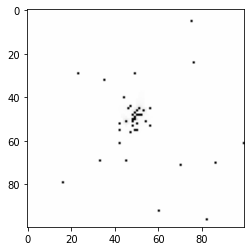

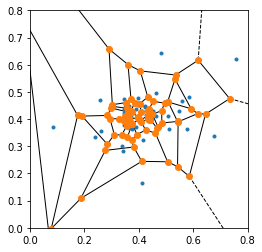

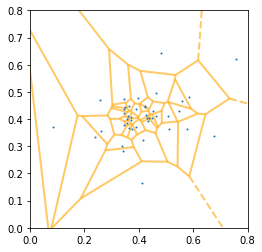

[371.903321, -393.178153, 482.335362, 729.555996] ----


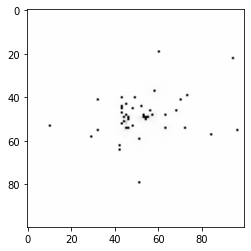

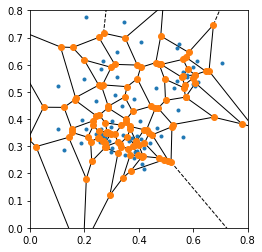

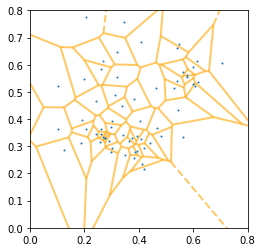

[-494.207629, 91.403258, 327.954593, 600.674953] ----


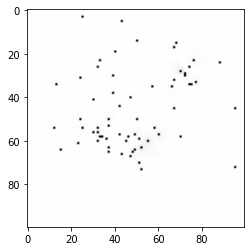

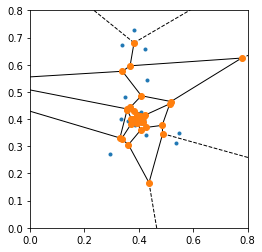

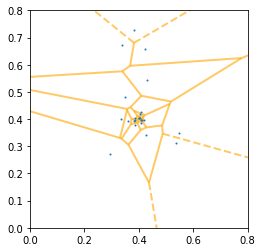

[236.537751, -520.863536, 577.695746, 814.403083] ----


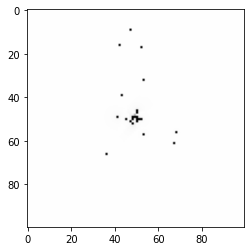

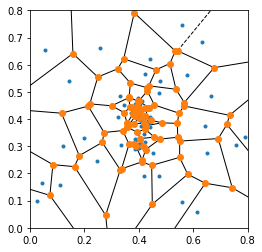

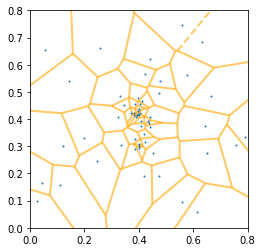

[-117.130191, 520.146795, -683.775920, 869.361357] ----


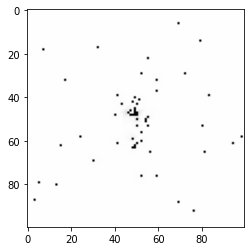

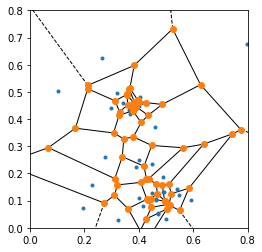

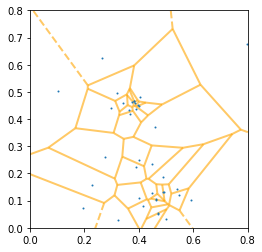

[361.075045, -431.386715, 1562.100809, 1663.032399] ----


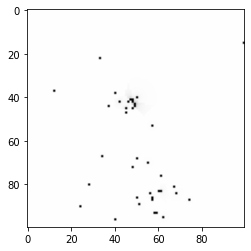

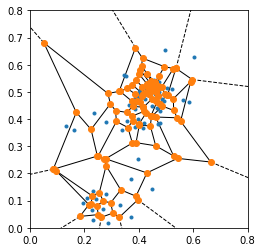

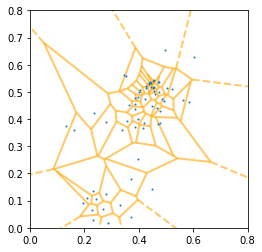

[517.181732, -163.998846, 41.122281, 545.726040] ----


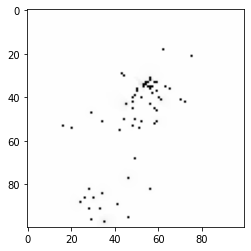

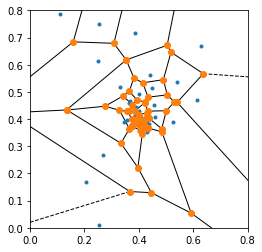

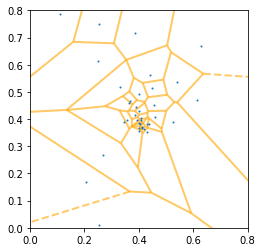

[481.923801, 159.745928, 419.577180, 665.716404] ----


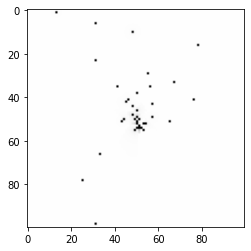

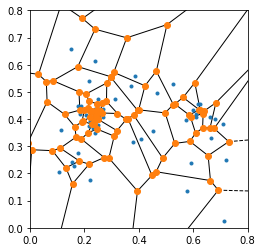

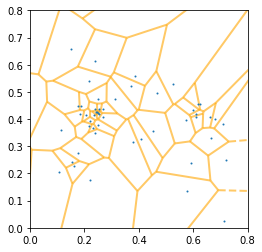

[-367.126141, 457.278106, -107.123836, 596.859127] ----


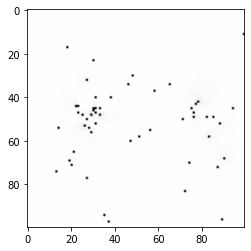

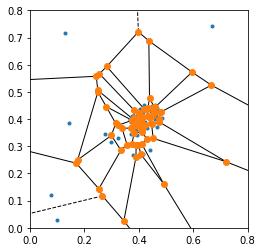

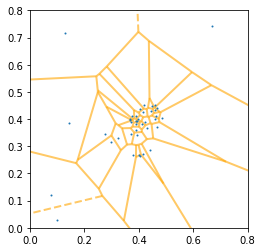

[396.932734, 334.845691, 593.636522, 789.637042] ----


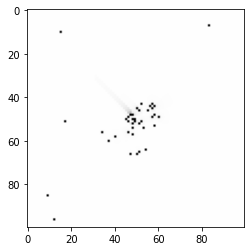

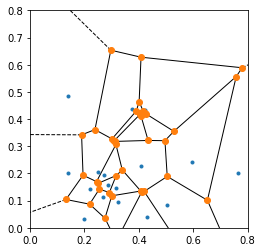

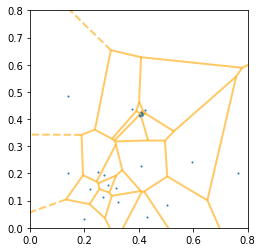

[547.686785, -142.483352, 543.778612, 786.699689] ----


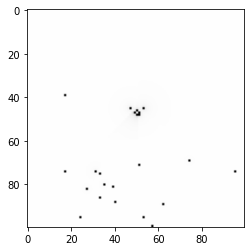

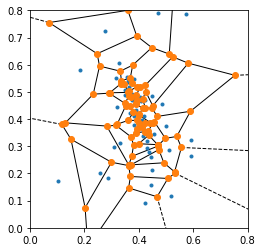

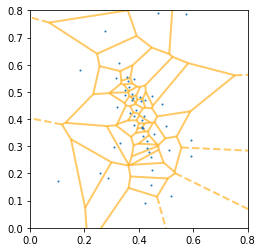

[-47.696759, -547.445769, 849.406588, 1011.763460] ----


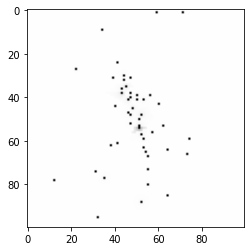

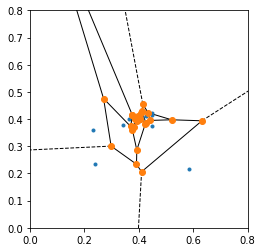

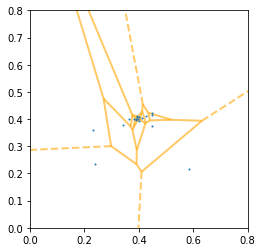

[-417.369538, -401.517772, -37.797660, 581.478691] ----


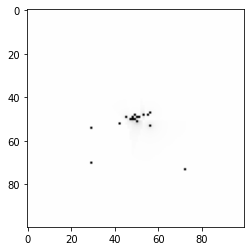

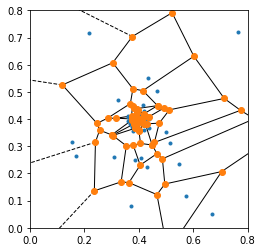

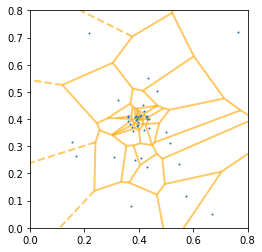

[450.733930, 254.388010, -332.827205, 615.904639] ----


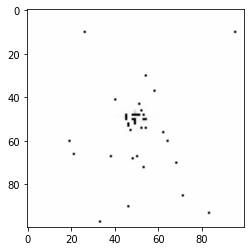

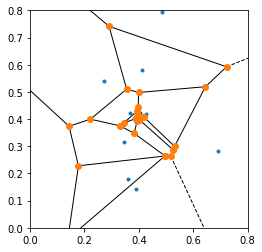

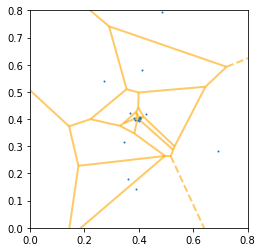

[-524.396570, -26.305080, -216.883699, 570.302461] ----


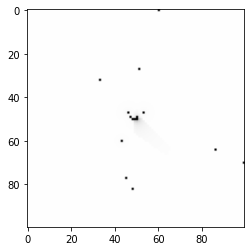

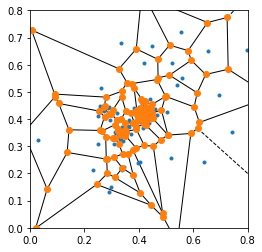

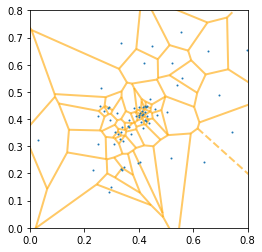

[-55.571029, -584.829073, -240.651654, 638.065474] ----


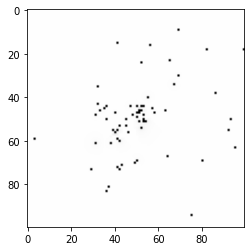

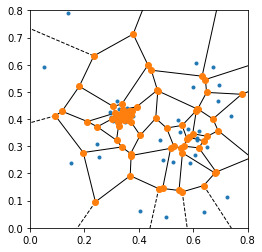

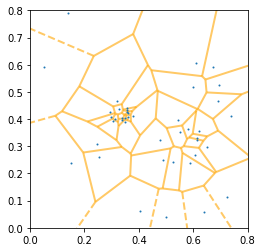

[366.264770, 457.838290, 330.347752, 679.971308] ----


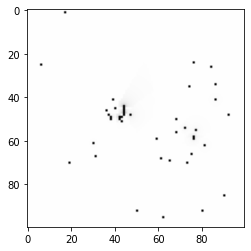

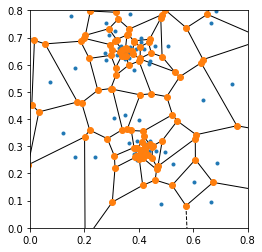

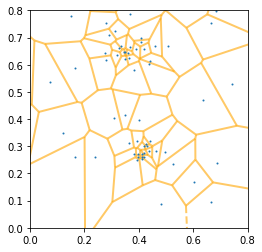

[-472.066106, 315.839991, -218.295104, 610.024160] ----


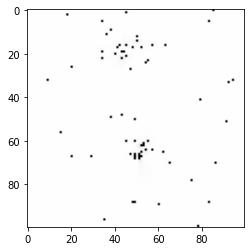

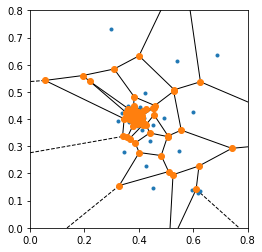

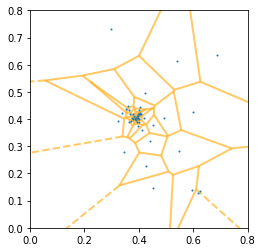

[-297.375617, -441.767067, 522.488075, 747.257219] ----


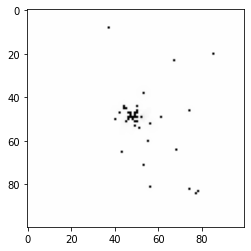

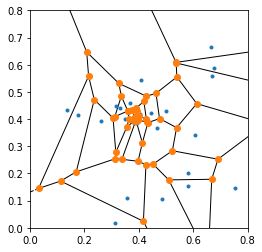

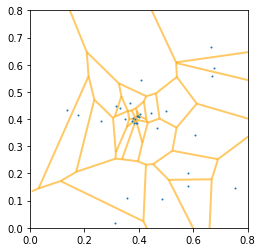

[32.421061, 566.765002, -933.623385, 1092.981008] ----


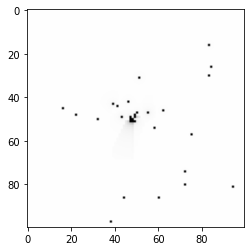

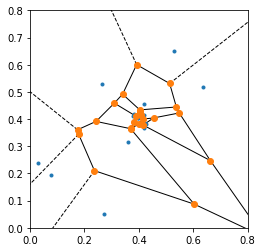

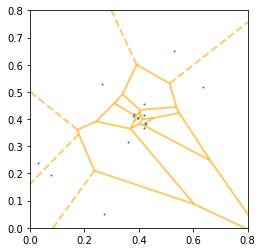

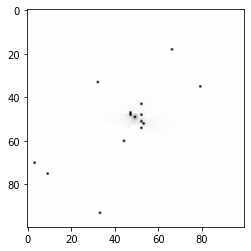

In [39]:
for i in range(25):
    j = get_next_jet()
    print(j, '----')
    plot1, plot2 = voronoi_pixels(j)

[501.000000, 0.000000, 0.000000, 501.000000]


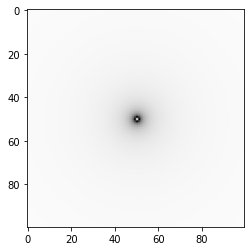

In [49]:
p = fj.PseudoJet(0,0,0,0)
p.reset_PtYPhiM(501, 0, 0, 0)
psjv = fj.vectorPJ()
psjv.push_back(p)
j = fj.sorted_by_pt(jet_def(psjv))
print(j[0])
plot1, plot2 = voronoi_pixels(j[0])

[502.000000, 0.000000, -0.000000, 502.025100]


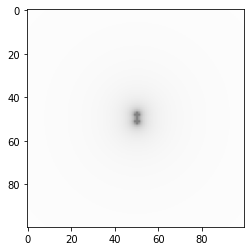

In [44]:
p = fj.PseudoJet(0,0,0,0)
psjv = fj.vectorPJ()
p.reset_PtYPhiM(251, -0.01, 0, 0)
psjv.push_back(p)
p.reset_PtYPhiM(251, 0.01, 0, 0)
psjv.push_back(p)
j = fj.sorted_by_pt(jet_def(psjv))
print(j[0])
plot1, plot2 = voronoi_pixels(j[0])

[500.987450, 2.509958, 0.500008, 501.012500]


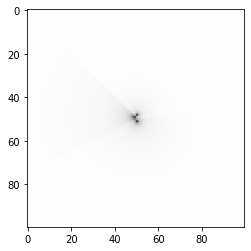

In [46]:
p = fj.PseudoJet(0,0,0,0)
psjv = fj.vectorPJ()
p.reset_PtYPhiM(100, -0.01, 0, 0)
psjv.push_back(p)
p.reset_PtYPhiM(150, 0.01, 0, 0)
psjv.push_back(p)
p.reset_PtYPhiM(251, 0.0, 0.01, 0)
psjv.push_back(p)
j = fj.sorted_by_pt(jet_def(psjv))
print(j[0])
plot1, plot2 = voronoi_pixels(j[0])

[751.937252, -2.509707, 5.520343, 752.062702]


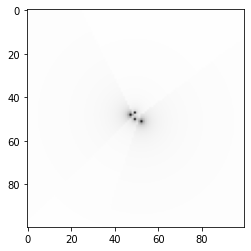

In [47]:
p = fj.PseudoJet(0,0,0,0)
psjv = fj.vectorPJ()
p.reset_PtYPhiM(100, -0.01, 0, 0)
psjv.push_back(p)
p.reset_PtYPhiM(150, 0.01, 0, 0)
psjv.push_back(p)
p.reset_PtYPhiM(251, 0.0, 0.01, 0)
psjv.push_back(p)
p.reset_PtYPhiM(251, 0.02, -0.02, 0)
psjv.push_back(p)
j = fj.sorted_by_pt(jet_def(psjv))
print(j[0])
plot1, plot2 = voronoi_pixels(j[0])